# Sparse linear models (LASSO)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/expl_lasso.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt
import mlcolvar.utils.plot

# Set seed for reproducibility
torch.manual_seed(1)

In this notebook we show how to identify the most relevant features for a model using a sensitivity analysis based on the partial derivatives. This has been used to gain insights into the workings of the [Deep-LDA](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) and [DeepTICA](https://www.pnas.org/doi/10.1073/pnas.2113533118https://www.pnas.org/doi/10.1073/pnas.2113533118) CVs.

## Train a ML CV

We will use the DeepLDA CV trained for the [intermolecular aldol reaction](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_DeepLDA.ipynb) from the [examples](https://mlcolvar.readthedocs.io/en/stable/examples.html) as a case study to explore the sensitivity analysis method.  Of course, the same analysis can be applied also to the other CVs.

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.R", 
              "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.P" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'cc|oo|co|ch|oh' }, # select contacts 
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 43)
Class 1 dataframe shape:  (5001, 43)

 - Loaded dataframe (10002, 43): ['time', 'cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11', 'walker', 'labels']
 - Descriptors (10002, 40): ['cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11']


In [4]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.cvs import AutoEncoderCV

# define model
n_input           = dataset['data'].shape[-1]
nodes             = [40,30,30,1]
nn_args           = {'activation': 'shifted_softplus'}
options           = {'encoder': nn_args}

model = AutoEncoderCV(nodes, options=options)

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0., patience=10)

# define trainer
trainer = lightning.Trainer(accelerator='cpu', callbacks=[metrics, early_stopping],
                     max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | MSELoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 40]  | [1, 40]  
2 | encoder | FeedForward   | 2.2 K  | [1, 40]  | [1, 1]   
3 | decoder | FeedForward   | 2.2 K  | ?        | ?        
-----------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s, v_num=19]          

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s, v_num=19]


### Create labels and dataset

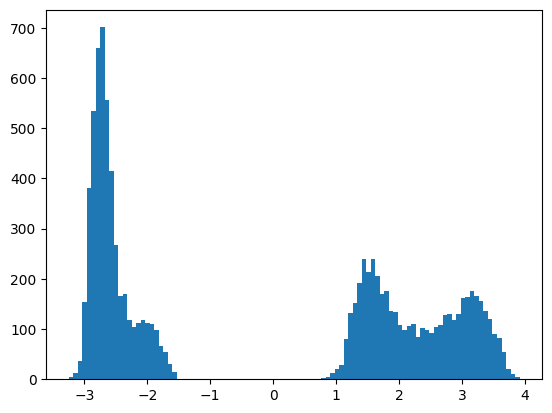

In [5]:
with torch.no_grad():
    s = model(dataset['data']).cpu().numpy()

plt.hist(s,bins=100)
plt.show()

In [6]:
labels = np.zeros_like(s)
labels[np.argwhere(s<0)] = 1
labels[np.argwhere(s>0)] = 2

dataset['labels'] = torch.Tensor(labels).squeeze(-1)

# Sparse linear models

## LASSO classifier

Scoring function
$$\text{score} = - (1-\text{accuracy})*100 - \left|n-\text{min\_features}\right| $$

Classification

In [7]:
from mlcolvar.utils.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, plot = False)

======= LASSO results (2) ========
- Regularization : 0.00025719
- Score          : -1.00
- Accuracy       : 100.00%
- # features     : 1

Features: 
(1) cc2.1        : -0.442824



Plot

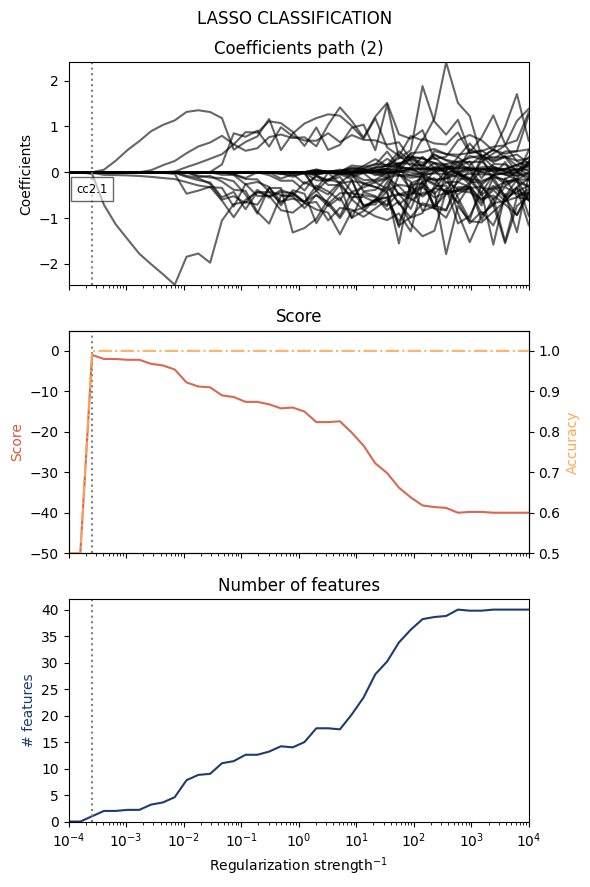

In [8]:
from mlcolvar.utils.lasso import plot_lasso_classification

fig,axs = plot_lasso_classification(classifier,feats,coeffs)

Change regularization parameters

======= LASSO results (2) ========
- Regularization : 0.00025719
- Score          : -1.00
- Accuracy       : 100.00%
- # features     : 1

Features: 
(1) cc2.1        : -0.442824



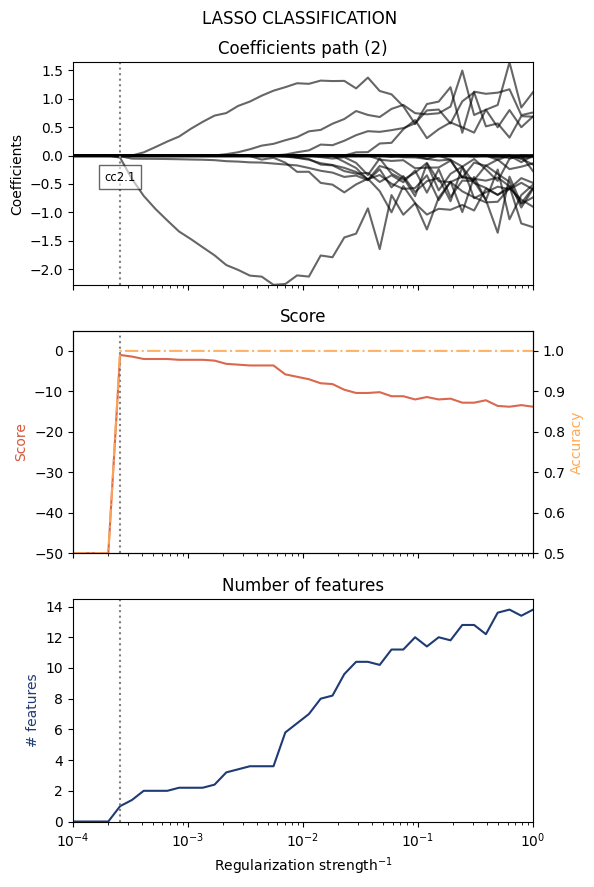

In [9]:
from mlcolvar.utils.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, Cs=np.logspace(-4,0,40))

Find at least a minimum number of features

In [10]:
from mlcolvar.utils.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, Cs=np.logspace(-4,0,40), min_features=3, plot=False)

======= LASSO results (2) ========
- Regularization : 0.00215443
- Score          : 0.00
- Accuracy       : 100.00%
- # features     : 3

Features: 
(1) cc2.1        : -2.033580
(2) oh2.3        : 0.936075
(3) co2.5        : 0.069181



Select a given regularization value 

In [11]:
classifier, feats, coeffs = lasso_classification(dataset, Cs = [1e-3], plot=False)

======= LASSO results (2) ========
- Regularization : 0.00100000
- Score          : -2.20
- Accuracy       : 99.80%
- # features     : 2

Features: 
(1) cc2.1        : -1.596923
(2) oh2.3        : 0.601655



## LASSO regressor

$$\frac{1}{2\ \text{n\_samples}} ||y - Xw||^2_2 + \alpha\ ||w||_1$$

Use CV values as target

In [12]:
with torch.no_grad():
    dataset['target'] = model(dataset['data']).squeeze(-1)

========= LASSO results ==========
- Regularization : 0.00249221
- Score          : 0.99759764
- # features     : 27

======= Relevant features =======
(1) oh2.3        : 0.801470
(2) oh2.9        : -0.772326
(3) ch2.15       : -0.350035
(4) ch2.9        : 0.266894
(5) oo2.0        : -0.166953
(6) oh2.1        : -0.155276
(7) oh2.6        : -0.124781
(8) oh2.0        : -0.119380
(9) ch2.12       : -0.083712
(10) oh2.7        : -0.077145
(11) ch2.11       : -0.057809
(12) co2.0        : 0.051210
(13) co2.2        : -0.050499
(14) oh2.8        : -0.046496
(15) ch2.6        : 0.029131
(16) co2.4        : -0.024428
(17) ch2.13       : 0.022322
(18) co2.5        : 0.020196
(19) co2.3        : 0.019344
(20) ch2.2        : -0.017554
(21) ch2.14       : 0.014595
(22) ch2.7        : 0.010484
(23) ch2.1        : 0.010402
(24) ch2.8        : 0.010357
(25) oh2.2        : -0.006195
(26) ch2.10       : 0.003651
(27) oh2.4        : -0.002161


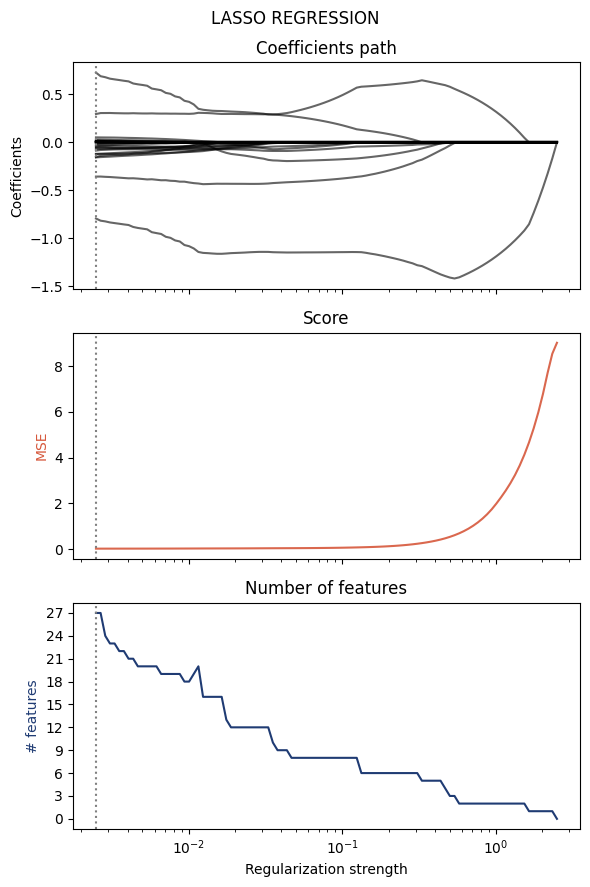

In [13]:
from mlcolvar.utils.lasso import lasso_regression

regressor, feats, coeffs = lasso_regression(dataset, alphas=None, plot=True)

In [22]:
regressor, feats, coeffs = lasso_regression(dataset, alphas=[1])

========= LASSO results ==========
- Regularization : 1.00000000
- Score          : 0.83081775
- # features     : 2

======= Relevant features =======
(1) oh2.9        : -1.188324
(2) oh2.3        : 0.318383
Plotting is not available, as the regressor has been optimized with a single regularization value.


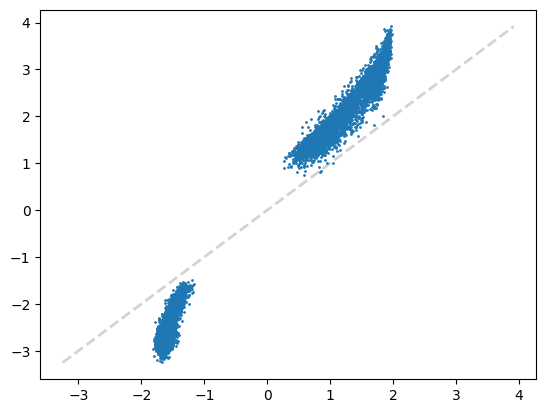

In [23]:
with torch.no_grad():
    X = dataset['data'].numpy()
    y = dataset['target'].numpy()

from sklearn.preprocessing import StandardScaler 
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

y_pred = regressor.predict(X)

plt.scatter(y_pred, y,s=1)
plt.plot([y.min(),y.max()],[y.min(),y.max()],linewidth=2,color='lightgrey',zorder=0,linestyle='dashed')